In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
dirname = "sotsuken/"
os.makedirs(dirname, exist_ok=True)
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size
import numpy as np
import scipy.linalg as la

import quantecon as qe

In [24]:
# 効用関数の設定
# LQR_util = 2で効用をマイナスに設定
# LQR_util = 2ではLQRの重み行列が正定値行列とならず破綻
LQR_util = 3

In [25]:
mu_d = 13.
rho = 0.05
gan = 13.
c_d = .2
#beta_std = 0.9494764430324878
beta_std = 0.95
R_kinri = 1 / beta_std
ponji = 1e-9

In [26]:
iter_t = 1500
iter_uti= iter_t

In [27]:
np.random.seed(818931331)
eps = np.random.randn(iter_t) + (1-rho)*(mu_d-gan)/c_d

In [28]:
print(eps.shape)
print(eps[:10])

(1500,)
[ 0.35555431 -0.60040183 -1.14844746 -0.49146327 -0.04967777 -0.86739363
  0.40975609  1.05405199 -1.86230537 -0.44658328]


In [29]:
sig_arr = [-1e-9, -1e-1]
d_first = 14.0
k_first = 0.0

In [30]:
ovr = 50
tapple_y = 50
y_lim = (0, 20)

In [31]:
# おまじない
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
# olrprobust_3はリカッチのif文を削除した
# olrprobust_2との相違点は上記があるか、ないか
from olrprobust_3_using import olrp, olrprobust, doubleo

# olrprobust_2はリカッチのif文有〼
# matlabを極力そのまま移し替えた。
# from olrprobust_2_using import olrp, olrprobust, doubleo

# olrprobust_1はgithubから
# from olrprobust_1_using import olrp,olrprobust,doubleo

In [33]:
# y=[d k]のやつ
QLQ_mat = np.array([[0.0, 0.0], [0.0, ponji]])
ALQ_mat = np.array(
    [[rho, 0.0], [1.0, R_kinri]]
)
# u=\gamma - c_tにしたため符号を反転した
BLQ_mat = np.array([[0.0], [1.0]])
CLQ_mat = np.array([ [c_d], [0.0]])
RLQ_mat = np.array([[1]])

if LQR_util == 2:
    RLQ_mat = -RLQ_mat
    QLQ_mat = -QLQ_mat
F_nomis_mat, K_nomis_mat, P_nomis_mat, Pt_nomis_mat = olrprobust(
    beta_std, ALQ_mat, BLQ_mat, CLQ_mat, QLQ_mat, RLQ_mat, sig_arr[0]
)
print(f"F = {F_nomis_mat[0]}")

print(P_nomis_mat)
print(np.linalg.eigvals(P_nomis_mat))

F = [0.05249348 0.05263162]
[[0.05511126 0.05525629]
 [0.05525629 0.0554017 ]]
[4.99873136e-10 1.10512963e-01]


In [34]:
y_nomis_mat = np.array([[d_first, k_first]])
ABF_nomis_mat = ALQ_mat - BLQ_mat @ F_nomis_mat
for i in range(iter_t):
    y_nomis_mat = np.insert(
        y_nomis_mat, 0, ABF_nomis_mat @ y_nomis_mat[0].T + CLQ_mat.T * eps[i]*0, axis=0
    )

In [35]:
# 0-iter_tまでのiter_t+1の長さになっている。
y_nomis_mat = y_nomis_mat[::-1]
k_nomis_mat = y_nomis_mat[:, 1]
d_nomis_mat = y_nomis_mat[:, 0] + gan

In [36]:
print(f"y.shape = {y_nomis_mat.shape}")

y.shape = (1501, 2)


In [37]:
c_nomis_mat = np.zeros(iter_t + 1)
for i in range(iter_t + 1):
    c_nomis_mat[i] = F_nomis_mat @ y_nomis_mat[i] + gan
print(f"c.shape = {c_nomis_mat.shape}")

c.shape = (1501,)


In [38]:
import numpy.linalg as LA
stability=ALQ_mat-BLQ_mat@F_nomis_mat
print(LA.eig(stability))
print(LA.eig(ALQ_mat))
print(LA.eig(P_nomis_mat))

(array([0.99999996, 0.05      ]), array([[ 0.        ,  0.70803535],
       [ 1.        , -0.70617699]]))
(array([1.05263158, 0.05      ]), array([[ 0.        ,  0.70803535],
       [ 1.        , -0.70617699]]))
(array([4.99873136e-10, 1.10512963e-01]), array([[-0.70803535, -0.70617699],
       [ 0.70617699, -0.70803535]]))


In [39]:
BtLQ_mat=np.hstack([BLQ_mat,CLQ_mat])
print(BtLQ_mat)

[[0.  0.2]
 [1.  0. ]]


In [40]:
print(ALQ_mat)

[[0.05       0.        ]
 [1.         1.05263158]]


In [41]:
print(ALQ_mat**2)

[[0.0025     0.        ]
 [1.         1.10803324]]


In [42]:
Co = np.hstack([BtLQ_mat, ALQ_mat * BtLQ_mat, ALQ_mat**2 * BtLQ_mat])
print(Co)

[[0.  0.2 0.  0.  0.  0. ]
 [1.  0.  1.  0.  1.  0. ]]


In [43]:
np.linalg.matrix_rank(Co)

2

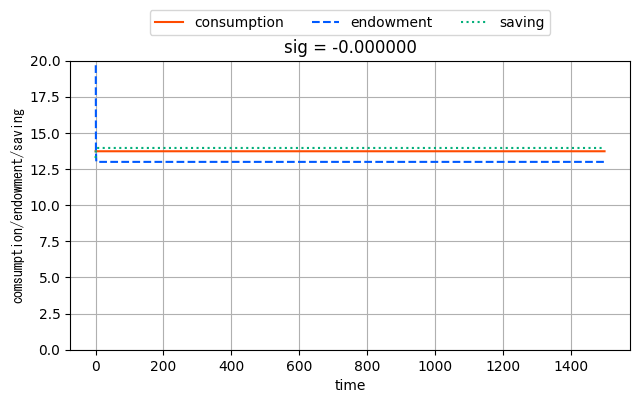

In [44]:
plt.figure(figsize=[6.5, 4.2])
plt.title("sig = %f" % (sig_arr[0]))
plt.ylim(y_lim)
colorlist = ["#FF4B00", "#005AFF", "#03AF7A"]
# Plot consumption
plt.plot(
    np.array(range(iter_t+1)),
    c_nomis_mat[:iter_t+1],
    linestyle="-",
    label="consumption",
    color=colorlist[0],
)

# Plot endowment
plt.plot(
    np.array(range(iter_t)),
    d_nomis_mat[:iter_t],
    linestyle="--",
    label="endowment",
    color=colorlist[1],
)

# Plot saving
plt.plot(
    np.array(range(iter_t)),
    k_nomis_mat[1:iter_t+1],
    linestyle=":",
    label="saving",
    color=colorlist[2],
)

# Legend with specified arguments
plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.2), ncol=3, prop={"size": 10})
plt.xlabel("time", fontsize=10)
plt.ylabel("comsumption/endowment/saving", fontname="MS Gothic", fontsize=10)
plt.grid()
plt.tight_layout()
plt.savefig("%sch10_1.png" % dirname)

In [45]:
import numpy as np
import statsmodels.api as sm

# 乱数シードを設定して再現性を保つ
np.random.seed(42)

# 仮想の時系列データを生成 (AR(1)プロセス)
# AR(1) パラメータ: φ = 0.8, 定数項 = 0, 標準偏差 = 1
phi = 0.8
n = 100
error = np.random.normal(0, 1, n)
time_series = np.zeros(n)
time_series1 = np.zeros(n)

for i in range(1, n):
    if i==1:
        time_series[i]=10
        time_series1[i]=10
    else:
        time_series[i] = phi * time_series[i-1] + error[i]*0+14
        time_series1[i] = phi * time_series[i-1] + error[i]*0+16

# AR(1)モデルをフィット
model = sm.tsa.ARIMA(time_series, order=(1, 0, 0))
results = model.fit()

model1 = sm.tsa.ARIMA(time_series1, order=(1, 0, 0))
results1 = model1.fit()

# モデルのサマリーを表示
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -225.554
Date:                Mon, 18 Mar 2024   AIC                            457.108
Time:                        11:46:05   BIC                            464.923
Sample:                             0   HQIC                           460.271
                                - 100                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         38.0293     41.319      0.920      0.357     -42.955     119.013
ar.L1          0.9979      0.018     55.547      0.000       0.963       1.033
sigma2         5.0463      0.445     11.334      0.000       4.174       5.919
===================================================================================
Ljung-Box (L1) (Q):                  65.18   Jarque-Bera (JB):               931.54
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.00   Skew:                             3.59
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

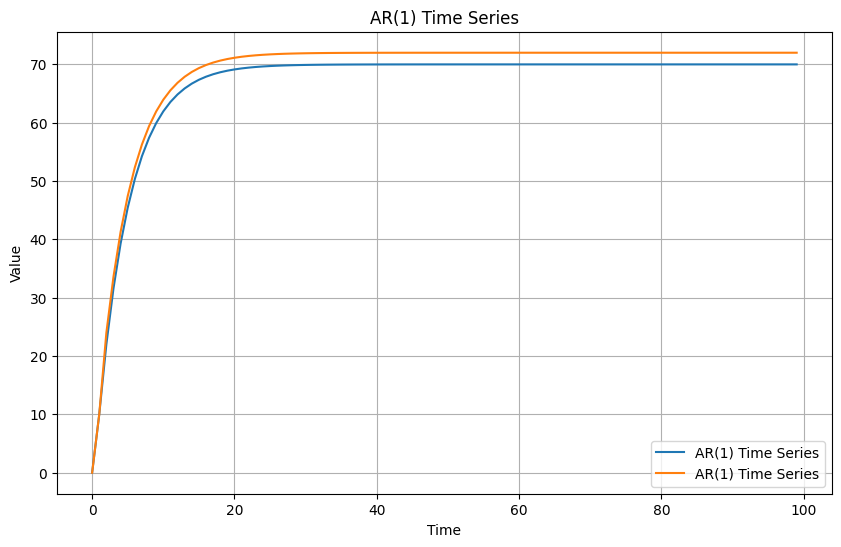

In [46]:
import matplotlib.pyplot as plt

# 時系列データのプロット
plt.figure(figsize=(10, 6))
plt.plot(time_series, label='AR(1) Time Series')
plt.plot(time_series1, label='AR(1) Time Series')
plt.title('AR(1) Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()